# From Context-independent to Context-Sensitive


# BERT: Combining the Best of Both worlds
Context bidirectionality + task-agnostic 
* ELMo encodes context bidirectionally but uses task=specific architectures \\
Second model is GPT. 
* GPT is task-agnostic but encodes context left-to-right \\




In [ ]:
pip install --upgrade d2l==1.0.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 445 kB/s 
     |████████████████████████████████| 121 kB 81.2 MB/s 
     |████████████████████████████████| 1.6 MB 76.8 MB/s 
     |████████████████████████████████| 82 kB 333 kB/s 


In [ ]:
pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l 

# Input Representation 


In [ ]:

def get_tokens_and_segments(tokens_a, tokens_b=None):
    tokens = ['<cls>'] + tokens_a + ['<sep>'] #[ '<cls>', tokens_a, '<sep>']
    # 0 and 1 are marking segment A and B, respectively
    segments = [0] * (len(tokens_a) + 2) # [0,0,0,...,0]
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

* Transformer encoder as its bidirectional architecture.
* learnable positional embeddings
* BERT=> transformer encoder with learnable positional embeddings. \\


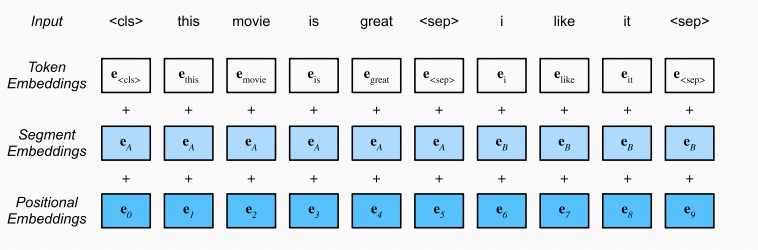

In [ ]:
class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

class PositionWiseFFN(nn.Module):
  def __init__(self, ffn_num_hiddens, ffn_num_outputs):
    super().__init__()
    self.densel = nn.LazyLinear(ffn_num_hiddens)
    self.relu = nn.ReLU()
    self.dense2 = nn.LazyLinear(ffn_num_outputs)
  def forward(self,X):
    return self.dense2(self.relu(self.densel(X)))



In [ ]:
class MultiHeadAttention(nn.Module):
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout, num_heads)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens, window_mask=None):
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)
        output = self.attention(queries, keys, values, valid_lens,
                                window_mask)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

    def transpose_qkv(self, X):
      X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
      X = X.permute(0, 2, 1, 3)
      return X.reshape(-1, X.shape[2], X.shape[3])


    def transpose_output(self, X):
      X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
      X = X.permute(0, 2, 1, 3)
      return X.reshape(X.shape[0], X.shape[1], -1)

In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self, num_hiddens, ffn_num_hiddens,num_heads, dropout, use_bias=False):
    super().__init__()
    self.attention = MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
    self.addnorml = AddNorm(num_hiddens, dropout)
    self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
    self.addnorm2 = AddNorm(num_hiddens, dropout)
  def forward(self,X,valid_lens):
    Y= self.addnorml(X,self.attention(X,X,X,valid_lens))
    return self.addnorm2(Y,self.ffn(Y))                                        


In [ ]:
class BERTEncoder(nn.Module):
    """BERT encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout, max_len=1000, **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, True))

        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, num_hiddens))

    def forward(self, tokens, segments, valid_lens):

        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

In [ ]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
ffn_num_input, num_blks, dropout = 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens, num_heads,num_blks, dropout)
               

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
print(encoded_X.shape)
encoded_X

torch.Size([2, 8, 768])


tensor([[[ 0.1201,  0.6204,  0.8422,  ...,  0.5554, -0.6017, -0.8898],
         [-0.2325,  0.2627, -0.6123,  ..., -0.9540, -0.4373, -0.1537],
         [-0.8072, -0.9987,  0.6842,  ..., -0.9663, -1.7796,  0.8325],
         ...,
         [-0.5908,  1.1947, -0.6824,  ..., -1.4570,  1.2085,  1.2104],
         [ 0.0390, -0.7227, -0.2971,  ...,  0.2009,  1.5547, -0.1987],
         [-0.8873,  0.9434,  0.1961,  ...,  0.2780, -0.0181,  0.9326]],

        [[-1.0256,  0.7061,  0.6300,  ..., -0.8308,  0.2104, -1.7929],
         [-0.3916, -0.2331,  0.9800,  ..., -0.5224, -0.4566,  0.9326],
         [-0.1331, -0.3830,  0.0952,  ...,  0.5450, -1.4650, -0.2659],
         ...,
         [ 0.0380,  1.7336, -0.0060,  ..., -0.2835,  0.4847,  1.4036],
         [ 1.1554, -1.7280, -0.3169,  ..., -0.1902,  1.0231, -1.3082],
         [-0.7114,  0.8673, -0.2460,  ..., -0.4684,  1.4327, -0.0519]]],
       grad_fn=<NativeLayerNormBackward0>)

# Pretraining Tasks


## Masked Language Modeling 
* To encoder context bidirectionally -> randomly masking tokens \\



In [ ]:
class MaskLM(nn.Module):
    def __init__(self, vocab_size, num_hiddens, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.LazyLinear(num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.LazyLinear(vocab_size))

    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # Suppose that `batch_size` = 2, `num_pred_positions` = 3, then
        # `batch_idx` is `torch.tensor([0, 0, 0, 1, 1, 1])`
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        print(X.shape)
        print([batch_idx, pred_positions])
        masked_X = X[batch_idx, pred_positions]
        print(masked_X.shape)
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        print(masked_X.shape)
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

In [ ]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 8, 768])
[tensor([0, 0, 0, 1, 1, 1]), tensor([1, 5, 2, 6, 1, 5])]
torch.Size([6, 768])
torch.Size([2, 3, 768])


torch.Size([2, 3, 10000])

In [ ]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
print(mlm_Y_hat.reshape((-1, vocab_size)).shape)
print( mlm_Y.reshape(-1).shape)
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([6, 10000])
torch.Size([6])


torch.Size([6])

# Next Sentence Prediction
* Logical relationship between text pairs => abinary classification tesk in its pretraining. 
* NextSentencePred class = one-hidden-layer MLP to predict wtheter the second sentence is the next sentence
To help understand the relationship between two text sequences, BERT considers a binary classification task, next sentence prediction, in its pretraining



In [ ]:
class NextSentencePred(nn.Module):
    """The next sentence prediction task of BERT."""
    def __init__(self, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.LazyLinear(2)

    def forward(self, X):
        # `X` shape: (batch size, `num_hiddens`)
        return self.output(X)

In [ ]:
encoded_X = torch.flatten(encoded_X, start_dim=1)
# input_shape for NSP: (batch size, `num_hiddens`)
nsp = NextSentencePred()
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

In [ ]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

# Putting it All together 
* BERTModel = BERTEncoder + MaskLM + NextSentencePred

1) Forward inference -> encoded BERT representations encoded_X 

2) predictions of masked language modeling mlm_Y_hat

3) next sentence prediction nsp_Y_hat



In [ ]:
class BERTModel(nn.Module):
    """The BERT model."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, max_len=1000):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens,
                                   num_heads, num_blks, dropout,
                                   max_len=max_len)
        self.hidden = nn.Sequential(nn.LazyLinear(num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens)
        self.nsp = NextSentencePred()

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # The hidden layer of the MLP classifier for next sentence prediction.
        # 0 is the index of the '<cls>' token
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

# Pretraining BERT


In [ ]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

In [ ]:
net = BERTModel(len(vocab), num_hiddens=128,
                    ffn_num_hiddens=256, num_heads=2, num_blks=2, dropout=0.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss = nn.CrossEntropyLoss()

In [ ]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [ ]:
def train_bert(train_iter, net, loss, vocab_size, device, num_steps):
    net(*next(iter(train_iter))[:4])
    net = nn.DataParallel(net).to(device)
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(device)
            segments_X = segments_X.to(device)
            valid_lens_x = valid_lens_x.to(device)
            pred_positions_X = pred_positions_X.to(device)
            mlm_weights_X = mlm_weights_X.to(device)
            mlm_Y, nsp_y = mlm_Y.to(device), nsp_y.to(device)
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, 'f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f}')

MLM loss 5.691, NSP loss 0.776
5927.1


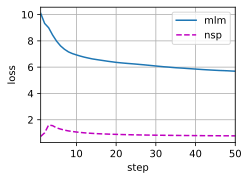

In [ ]:
train_bert(train_iter, net, loss, len(vocab), device, 50)


# Fine tuning of BERT 
Sentiment analysis with BERT of the Movie-reviews 

# data processing 

In [ ]:
!mkdir data
!wget -c https://github.com/agungsantoso/deep-learning-v2-pytorch/raw/master/sentiment-rnn/data/labels.txt
!wget -c https://github.com/agungsantoso/deep-learning-v2-pytorch/raw/master/sentiment-rnn/data/reviews.txt
!mv *.txt data/

--2022-11-06 02:01:38--  https://github.com/agungsantoso/deep-learning-v2-pytorch/raw/master/sentiment-rnn/data/labels.txt
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/agungsantoso/deep-learning-v2-pytorch/master/sentiment-rnn/data/labels.txt [following]
--2022-11-06 02:01:38--  https://raw.githubusercontent.com/agungsantoso/deep-learning-v2-pytorch/master/sentiment-rnn/data/labels.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225000 (220K) [text/plain]
Saving to: ‘labels.txt’

labels.txt          100%[===================>] 219.73K  --.-KB/s    in 0.009s  

2022-11-06 02:01:38 (24.5 MB/

In [ ]:
import numpy as np

with open('data/reviews.txt', 'r') as f:
  reviews = f.read() # long string 
with open('data/labels.txt', 'r') as f:
  labels = f.read() # long string


from string import punctuation

reviews = reviews.lower() 
all_text = ''.join([c for c in reviews if c not in punctuation]) # To remove punctuations 

reviews_split = all_text.split('\n')
all_text = ' '.join(reviews_split)

words = all_text.split()

from collections import Counter


counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab,1)} 

reviews_ints = [] # reveiw in reveiws_ints, review = [ noun1, noun2, noun3,...]
for review in reviews_split:
  reviews_ints.append([vocab_to_int[word] for word in review.split()])

labels_split = labels.split('\n')
labels = np.array([1 if label == 'positive' else 0 for label in labels_split])


## Install transformers 

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 14.5 MB/s 
     |████████████████████████████████| 163 kB 90.8 MB/s 
     |████████████████████████████████| 7.6 MB 80.0 MB/s 


## Upload BertTokenizer 


In [ ]:
from transformers import BertTokenizer
# load bert tokenizer
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny', do_lower_case=True)

encodings = tokenizer(reviews_split, truncation=True, padding='max_length', return_tensors='pt',
                      max_length=128)
input_ids = encodings['input_ids']
attention_masks = encodings['attention_mask']


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/285 [00:00<?, ?B/s]

## Make the datasets 

In [ ]:
from torch.utils.data import TensorDataset, random_split, DataLoader
# splitting traing and validation dataset
print(len(input_ids))
dataset = TensorDataset(input_ids, attention_masks, torch.tensor(labels))

train_size = int(len(input_ids) * 0.8)
val_size = len(reviews_split)  - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# load datasets into dataloaders
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
eval_dataloader = DataLoader(val_dataset, batch_size=16)

25001


## Make BertForSequenceClassification 

In [ ]:
import torch.nn as nn
import transformers 

class BertForSequenceClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert_model = transformers.BertModel.from_pretrained('prajjwal1/bert-tiny')
        self.dropout = nn.Dropout(0.25)
        self.classifier = nn.Linear(128, 1)
        
    def forward(self,ids,attention_mask, token_type_ids=None):

        _,o2= self.bert_model(ids, attention_mask=attention_mask,token_type_ids=token_type_ids, return_dict=False)
        

        out= self.classifier(self.dropout(o2))
        
        return out

## Train BERT Classifier 

In [ ]:
from transformers import  AdamW, get_scheduler
from tqdm.auto import tqdm


model = BertForSequenceClassification()

device = 'cuda'

loss_fn = nn.BCEWithLogitsLoss()

num_epochs = 4

optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
model.train()
model.to(device)
progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):
    for batch in train_dataloader:
  
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)[:,None]
        b_labels = b_labels.type(torch.float32)
        outputs = model(b_input_ids,attention_mask=b_input_mask) 
                           
        loss = loss_fn(outputs, b_labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

Downloading:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is d

  0%|          | 0/5000 [00:00<?, ?it/s]

## Evaluate BERT Classifier 

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = []
y_true = []
model.eval()
for batch in eval_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    # set gradient to zero at the start of every batch
    with torch.no_grad():
        output = model(b_input_ids,attention_mask=b_input_mask) 

    pred = torch.where(output >= 0, 1, 0)
  
    y_pred.extend(pred.tolist())
    y_true.extend(b_labels.tolist())
print(f'Accuracy: {accuracy_score(y_pred, y_true)}')

Accuracy: 0.8394321135772845
